# Dark diversity extended simulations

This notebook is an extension of the initial dark diversity simulation experiments. 

This simulation extends on the previous by considering more species and more diverse species distributions, to get a more complex network of species co-occurrences.

In [1]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(terra)
    library(tidyr)
    library(dplyr)
    library(DarkDiv)
    library(gamm4)
    library(emmeans)
})

set.seed(123)

# 1. Generating the environmental variables

Environmental variables for species distributions as well as drivers of dark diversity are generated as before, however this time we consider up to 6 environmental variables for species distributions, instead of 2 previously. We also have 3 different drivers of dark diversity, instead of 1 previously.

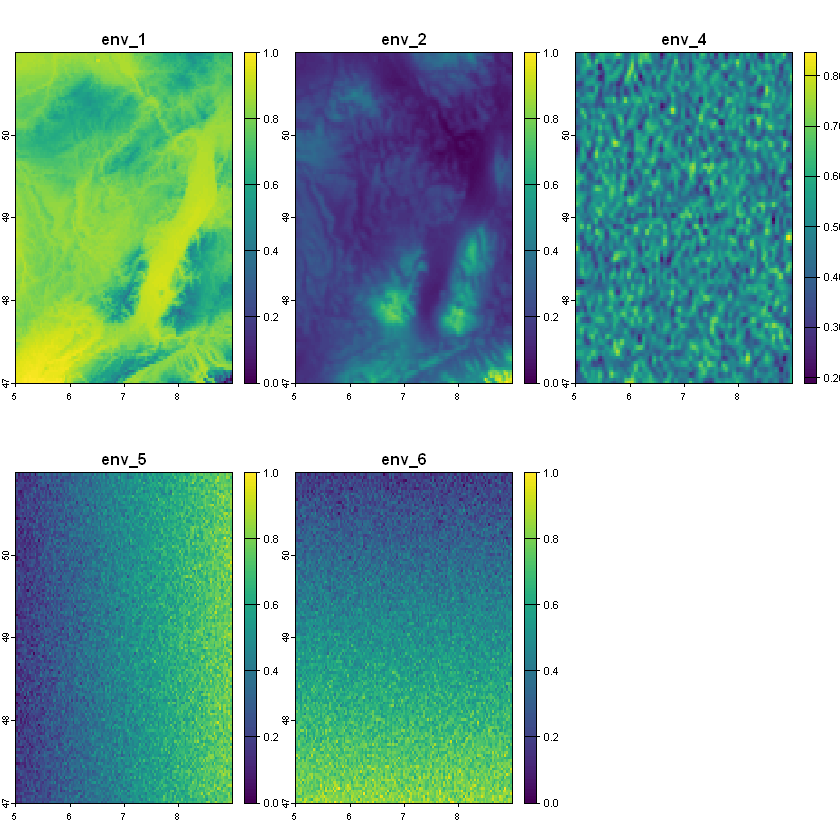

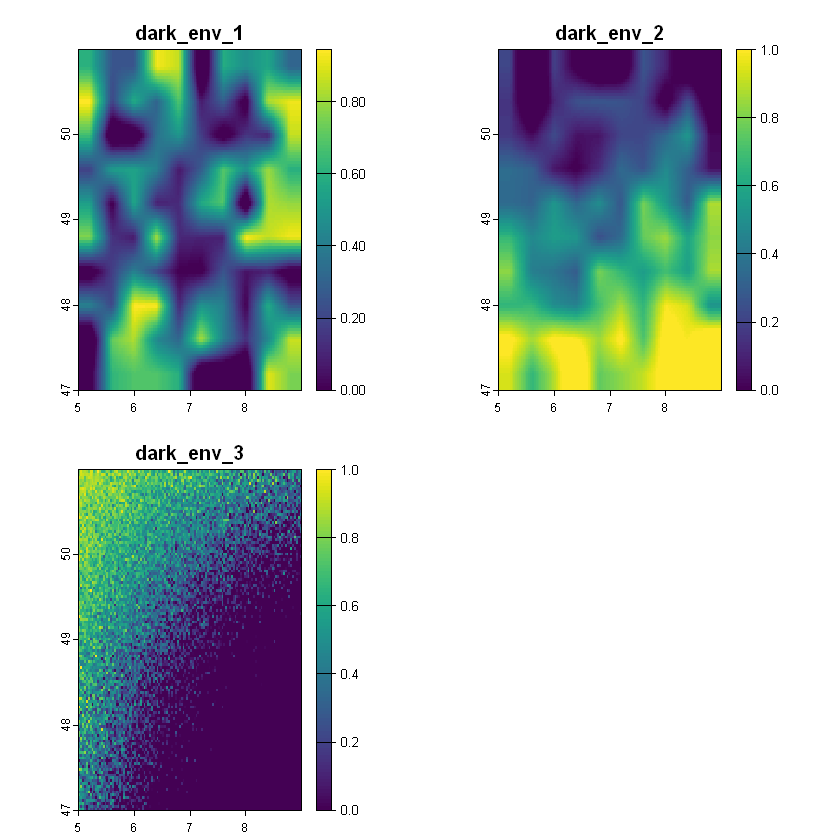

In [2]:
par(bg = "white")  # Set the background color and layout
# This uses cropped data from CHELSA bio1 and bio12 for central Europe
env_1 <- terra::rast("sim_data_chelsa\\bio1.tif") |> terra::aggregate(4)
values(env_1) <- scales::rescale(values(env_1))
env_2 <- terra::rast("sim_data_chelsa\\bio12.tif") |> terra::aggregate(4)
values(env_2) <- scales::rescale(values(env_2))

# Simulated environmental data
## Simulated factor data
env_3 <- terra::rast(terra::ext(env_1), nrows = nrow(env_1), ncols = ncol(env_1)) |>
    terra::aggregate(8)
values(env_3) <- round(runif(n = ncell(env_3), min = 0, max = 5))
env_3 <- terra::disagg(env_3, 8)

## Random normal data
env_4 <- terra::rast(terra::ext(env_1), nrows = nrow(env_1), ncols = ncol(env_1)) |>
    terra::aggregate(2)
values(env_4) <- rnorm(n = ncell(env_4), mean = 0, sd = 1) |>
    scales::rescale()
env_4 <- terra::resample(env_4, env_1)

## Gradient along x axis
env_5 <- terra::rast(terra::ext(env_1), nrows = nrow(env_1), ncols = ncol(env_1))
values(env_5) <- rep(
    seq(0, 10, length.out = nrow(env_1)), ncol(env_1)
) + rnorm(n = ncell(env_5), mean = 0, sd = 1)
values(env_5) <- values(env_5) |> scales::rescale()

## Gradient along y axis
env_6 <- terra::rast(terra::ext(env_1), nrows = nrow(env_1), ncols = ncol(env_1))
values(env_6) <- rep(
    seq(0, 10, length.out = ncol(env_6)),
    each = nrow(env_6)
) + rnorm(n = ncell(env_6), mean = 0, sd = 1)
values(env_6) <- values(env_6) |> scales::rescale()

envs <- c(
    env_1,
    env_2,
    # env_3,
    env_4,
    env_5,
    env_6
)

names(envs) <- c(
    "env_1",
    "env_2",
    # "env_3",
    "env_4",
    "env_5",
    "env_6"
)

# Now generate the dark diversity covariates
dark_env_1 <- terra::rast(
    terra::ext(env_1)
)
values(dark_env_1) <- runif(n = ncell(dark_env_1), min = 0, max = 1) * 1.3
dark_env_1 <- terra::resample(dark_env_1, env_1) |> terra::clamp(0, 1)
dark_env_1 <- 1 - dark_env_1

dark_env_2 <- terra::rast(
    terra::ext(env_1)
)
values(dark_env_2) <- rep(
    seq(1, 0, length.out = ncol(dark_env_2)),
    each = nrow(dark_env_2)
) + rnorm(n = ncell(dark_env_2), mean = 0, sd = 0.1) * 2
dark_env_2 <- terra::resample(dark_env_2, env_1) |> terra::clamp(0, 1)
dark_env_2 <- 1 - dark_env_2

dark_env_3 <- env_5 * (env_6 * 4)
values(dark_env_3) <- values(dark_env_3)
dark_env_3 <- terra::clamp(dark_env_3, 0, 1)
dark_env_3 <- 1 - dark_env_3

dark_envs <- c(
    dark_env_1,
    dark_env_2,
    dark_env_3
)

names(dark_envs) <- c(
    "dark_env_1",
    "dark_env_2",
    "dark_env_3"
)

plot(envs)
plot(dark_envs)

# 2. Generating species distributions

Using the 6 generated environmental variables, I will use the `virtualspecies` R package to generate a set of species distributions. This applies a gaussian/normal function to each of the environmental variables to generate a species distribution for each species.

A total of 25 species distributions will be generated, instead of only 3 previously. This will result in a more complex network of species co-occurrences, that should better predict dark diversity across the study area.


In [3]:
library(virtualspecies)

par(bg = "white")  # Set the background color and layout

n_species <- 25

sp_dists <- list()
for (i in 1:n_species) {
    sp_parameters <- virtualspecies::formatFunctions(
        env_1 = c(fun = "dnorm", mean = runif(1, min = minmax(env_1)[1], max = minmax(env_1)[2]), sd = runif(1, min = 0.1, max = 0.5)),
        env_2 = c(fun = "dnorm", mean = runif(1, min = minmax(env_2)[1], max = minmax(env_2)[2]), sd = runif(1, min = 0.1, max = 0.5)),
        env_4 = c(fun = "dnorm", mean = runif(1, min = minmax(env_4)[1], max = minmax(env_4)[2]), sd = runif(1, min = 0.1, max = 0.5)),
        env_5 = c(fun = "dnorm", mean = runif(1, min = minmax(env_5)[1], max = minmax(env_5)[2]), sd = runif(1, min = 0.1, max = 0.5)),
        env_6 = c(fun = "dnorm", mean = runif(1, min = minmax(env_6)[1], max = minmax(env_6)[2]), sd = runif(1, min = 0.1, max = 0.5)),
    )
    suppressMessages({
        sp_dists[[i]] <- virtualspecies::generateSpFromFun(
        raster.stack = envs[[c("env_1", "env_2", "env_4", "env_5", "env_6")]],
        parameters = sp_parameters
        )
    })
}

But rather than trying to always plot 25 species, lets only look at species 6, 10 and 25.

In [151]:
plot_species <- c("species_5", "species_6", "species_10", "species_25")

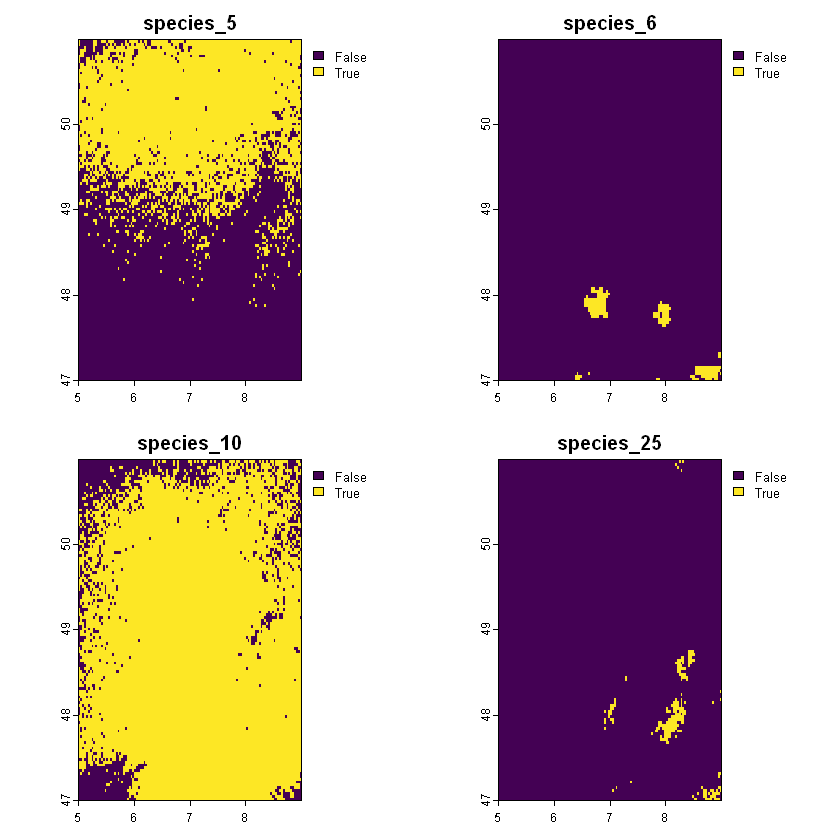

In [152]:
par(bg = "white", mfrow = c(2,2))  # Set the background color and layout

threshold <- 0.1

# for (i in seq_along(sp_dists)) {
#     plot(sp_dists[[i]]$suitab.raster > threshold)
# }

dist_list <- c()
for (i in seq_along(sp_dists)) {
    dist_list <- c(dist_list, sp_dists[[i]]$suitab.raster)
}
dist_stack <- terra::rast(dist_list)
names(dist_stack) <- paste0("species_", seq_along(sp_dists))

for (i in plot_species) {
    plot(dist_stack[[i]] > threshold, main = i)
}

Now we have the presence absence rasters of 25 generated species. We can then apply the dark diversity covariates to each species to generate the modified distribution. To keep it simple, it will be the application of one covariate for each species, with some species having none applied. 

We assume that in the absense of any driver of dark diversity, each species fully occupies its potential distribution, i.e. no species is in the dark diversity. 

The probability a species is in the dark diversity is calculated as:

`true probability x (1 - observed probability)`

The justification for this calculation is that the probability of a species being in the dark diversity is highest where the true and observed probabilities are most different. Where the true and observed probabilities are the same, the probability of a species being in the dark diversity is lower. This includes where the species is absent (true and observed probabilities are both low), and where the species is present (true and observed probabilities are both high), given that dark diversity is by definition where the species is not observed.


species,dark_cov_applied
<chr>,<int>
species_1,1
species_2,0
species_3,3
species_4,3
species_5,3
species_6,1
species_7,2
species_8,0
species_9,2


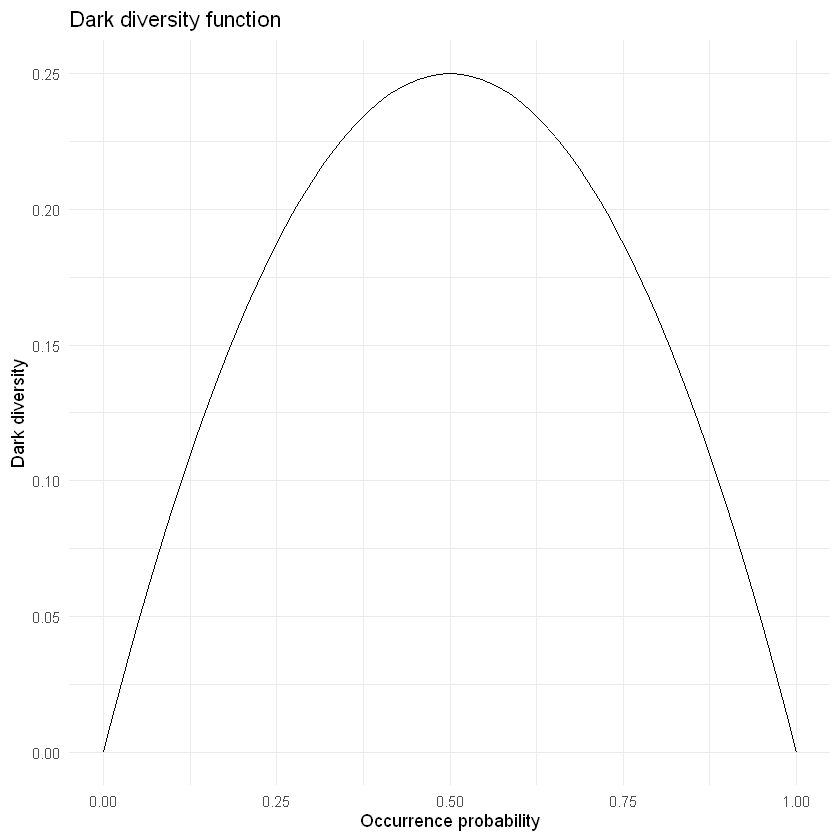

In [5]:
# Define which species is affect by which dark diversity covariate
dark_cov_applied <- sample(0:3, n_species, replace = TRUE)
# 0 = none, 1 = dark_env_1, 2 = dark_env_2, 3 = dark_env_3
# dark_cov_applied
dark_cov_df <- data.frame(species = paste0("species_", seq(1, n_species)), dark_cov_applied)
dark_cov_df

# Now apply the dark diversity covariates
dark_dist_list <- c()
for (i in 1:n_species) {
    if (dark_cov_applied[i] == 0) {
        dark_dist_list <- c(dark_dist_list, dist_stack[[i]])
    } else {
        dark_dist_list <- c(dark_dist_list, dist_stack[[i]] * dark_envs[[dark_cov_applied[i]]])
    }
}
dark_dist_stack <- terra::rast(dark_dist_list)

# Plotting the true dark diversity equation
par(bg = "white")
x = seq(0, 1, length.out = 100)
y = x*(1-x)
ggplot(data = data.frame(x = x, y = y), aes(x = x, y = y)) +
    geom_line() +
    labs(x = "Occurrence probability", y = "Dark diversity", title = "Dark diversity function") +
    theme_minimal()

Where there is no driver of dark diversity, this is the curve we would expect. I.e. the highest dark diversity probability is in the middle, between low occurrence probability (where the species cannot exist and by definition cannot be in the dark diversity) and high occurrence probability (where the species is present and by definition cannot be in the dark diversity).

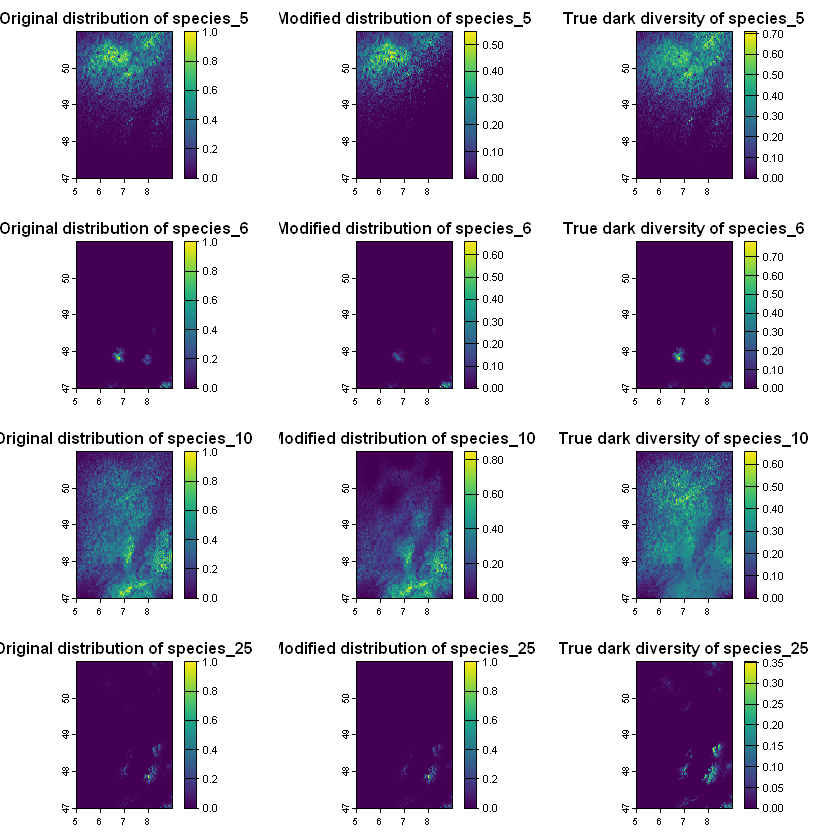

In [155]:
# Plotting original and modified species distributions and the true dark diversity
par(bg = "white", mfrow = c(4,3))

true_dark_div <- dist_stack * (1 - dark_dist_stack)

for (i in plot_species) {
    plot(dist_stack[[i]], main = paste("Original distribution of", i))
    plot(dark_dist_stack[[i]], main = paste("Modified distribution of", i))
    plot(true_dark_div[[i]], main = paste("True dark diversity of", i))
}

# par(bg = "white")  # Set the background color and layout
# plot(dark_dist_stack)
# mtext("Modified species distributions", line = -1, outer = TRUE)

# plot(dist_stack)
# mtext("Original species distributions", line = -1, outer = TRUE)

# true_dark_div <- dist_stack * (1 - dark_dist_stack)
# par(bg = "white")
# plot(true_dark_div)
# mtext("True dark diversity", line = -1, outer = TRUE)

Plotting the now modified dark diversity distributions:

# 3. Sampling the study area

Identically to the previous simulation, a set of 100 points will be sampled across the site, from which presence/absence for the species will be obtained. Where the probability of occurrence is above the threshold, the species is present. The dark diversity will be calculated for each species at each point.

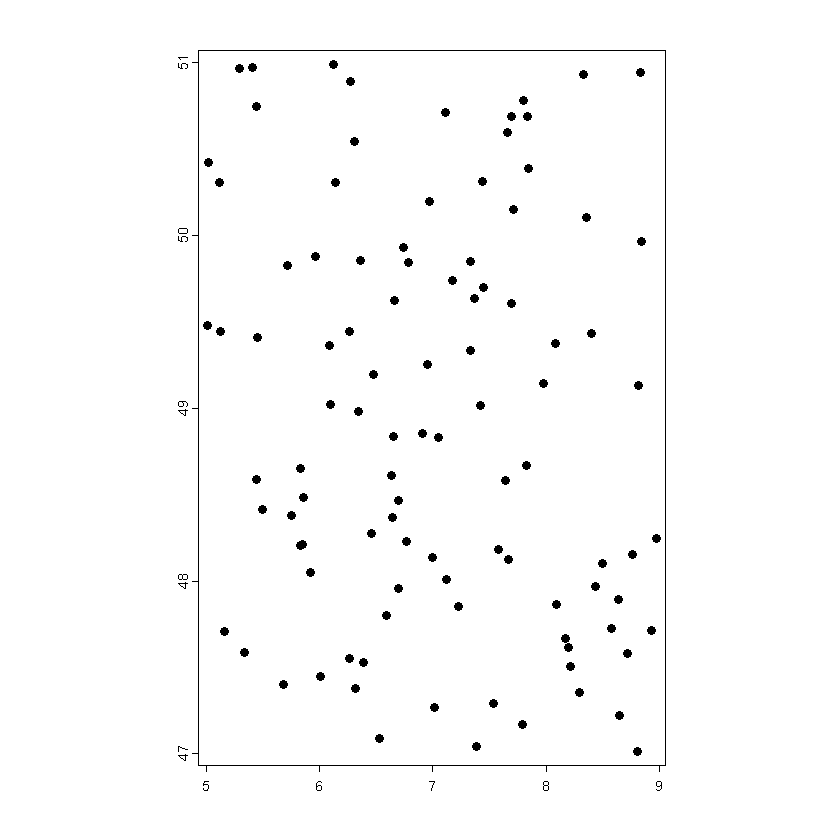

In [7]:
all_plots <- data.frame(
    x = runif(100000, ext(env_1)[1], ext(env_1)[2]),
    y = runif(100000, ext(env_1)[3], ext(env_1)[4])
) |> terra::vect(geom = c("x", "y"))


# Number of plots to use so we can easily change it
n_plots <- 100

plots <- sample(all_plots, n_plots)

par(bg = "white")
plot(plots)

In [8]:
observations <- terra::extract(dark_dist_stack, plots)[,-1] > threshold
apply(observations, 2, sum)

observations <- observations[, -c(15, 17, 19)]
head(observations)

species_1  species_2  species_3  species_4  species_5  species_6  species_7 
         4         16          1          8         22          1          4 
 species_8  species_9 species_10 species_11 species_12 species_13 species_14 
        12          3         59          7          4          3          3 
species_15 species_16 species_17 species_18 species_19 species_20 species_21 
         0          3          0          5          0          4          2 
species_22 species_23 species_24 species_25 
         9          4         21          2

species_1,species_2,species_3,species_4,species_5,species_6,species_7,species_8,species_9,species_10,⋯,species_13,species_14,species_16,species_18,species_20,species_21,species_22,species_23,species_24,species_25
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,⋯,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE


Due to the small distributions or low occurrence probabilities of species 15, 17 and 19, they were not sampled at all in the 100 points, so they were removed from the analysis.

In [9]:
species <- colnames(observations)
species

[1] "species_1"  "species_2"  "species_3"  "species_4"  "species_5" 
 [6] "species_6"  "species_7"  "species_8"  "species_9"  "species_10"
[11] "species_11" "species_12" "species_13" "species_14" "species_16"
[16] "species_18" "species_20" "species_21" "species_22" "species_23"
[21] "species_24" "species_25"

# 4. Calculating the dark diversity

Using the `DarkDiv` package, the dark diversity across each point is calculated using the hypergeometric method. This returns a probability value for each species at each point based on the co-occurrences of other species. 

Where none of the 25 species is present, the probability returned is `NaN`, and we keep it as such. 

Where the species is observed, the dark diversity probability is by definition 0, as the species is observed, and so we will replace the `NA` with 0.

In [180]:
dd <- DarkDiv::DarkDiv(observations)
dark_div <- dd$Pool
dark_div_zerofilled <- ifelse(dark_div == 1, 0, dark_div)
# dark_div_zerofilled <- ifelse(is.nan(dark_div), 0, dark_div)

head(dark_div_zerofilled)


species_1,species_2,species_3,species_4,species_5,species_6,species_7,species_8,species_9,species_10,⋯,species_13,species_14,species_16,species_18,species_20,species_21,species_22,species_23,species_24,species_25
0.72828997,0.9233741,0.2458120,0.1728788013,1.300435e-02,0.2458120,0.3577737,0.35036099,0.7175143,0.000000e+00,⋯,0.2707849,0.7175143,0.0000000,0.4295531,0.7479176,0.3993469,0.75036350,0.7479176,2.461663e-03,0.3993469
0.97842732,0.0115263,0.7593580,0.9982998185,0.000000e+00,0.3003714,0.1439152,0.99461027,0.1799028,2.100179e-10,⋯,0.4208468,0.1799028,0.8865349,0.6834257,0.1439152,0.5511515,0.05075728,0.1439152,0.000000e+00,0.2284774
0.00000000,0.9141525,0.2413836,0.4255582181,3.072845e-02,0.2413836,0.3471172,0.29031573,0.7090965,0.000000e+00,⋯,0.2626599,0.7090965,0.8031931,0.8302356,0.7386704,0.3916108,0.73611651,0.7386704,9.288794e-03,0.3916108
0.08015661,0.9998527,0.1151486,0.0002160367,1.156858e-10,0.1151486,0.3550760,0.02759197,0.9276726,0.000000e+00,⋯,0.1805808,0.9276726,0.1805808,0.5185087,0.9547800,0.3973924,0.97138564,0.9547800,3.780917e-10,0.3973924
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
0.97842732,0.0115263,0.7593580,0.9982998185,0.000000e+00,0.3003714,0.1439152,0.99461027,0.1799028,2.100179e-10,⋯,0.4208468,0.1799028,0.8865349,0.6834257,0.1439152,0.5511515,0.05075728,0.1439152,0.000000e+00,0.2284774


# 5. Spatially interpolating dark diversity

From the previous simulation, we found that using a GAM model to interpolate the dark diversity across the study area was the most effective method. We will use this method again to interpolate the dark diversity across the study area.

First let us define a function to fit the interpolation model:

In [181]:
fit_dark_div <- function(resp_mat, points, envs, model = "gam") {
    # resp_mat: Response matrix with species as columns and plots as rows, with values
    #           being the dark diversity probabilities
    # points:   SpatVect object of the plots where the observations were made
    # envs:     SpatRast stack with the environmental covariates
    #           All covariates will be used in the model fitting.
    # model:    Type of model to fit, either "gam" or "randomForest"

    # Returns:  A list with indexed by species names, containing the fitted model object

    env_values <- terra::extract(envs, points)[, -1] # Remove the ID column
    covars <- colnames(env_values)
    species <- colnames(resp_mat)

    fitted_models <- list("species" = c())
    for (s in species) {
        if (model == "gam") {
            tryCatch(
                {
                    formula <- as.formula(
                        paste("resp ~", paste0("s(", covars, ")", collapse = " + "))
                    )
                    fitted_models[[s]]$model <- mgcv::gamm(
                        formula,
                        data = data.frame(resp = resp_mat[, s], env_values),
                    )
                    fitted_models[[s]]$prediction <- predict(
                        envs,
                        fitted_models[[s]]$model$gam,
                        type = "response"
                    ) |> terra::clamp(0, 1)
                    fitted_models[["species"]] <- append(fitted_models[["species"]], s)
                },
                error = function(e) {
                    message(paste("Error fitting model for species:", s))
                    fitted_models[[s]] <- NULL
                }
            )
        } else if (model == "randomForest") {
            tryCatch(
                {
                    formula <- as.formula(
                        paste("resp ~", paste(covars, collapse = " + "))
                    )
                    fitted_models[[s]]$model <- randomForest::randomForest(
                        formula,
                        data = data.frame(resp = resp_mat[, s], env_values),
                        na.action = na.omit,
                        importance = TRUE
                    )
                    fitted_models[[s]]$prediction <- terra::predict(
                        envs,
                        fitted_models[[s]]$model,
                        type = "response"
                    ) |> terra::clamp(0, 1)
                    fitted_models[["species"]] <- append(fitted_models[["species"]], s)
                },
                error = function(e) {
                    message(paste("Error fitting model for species:", s))
                    fitted_models[[s]] <- NULL
                }
            )
        } else {
            stop("Model type not recognized. Use 'gam' or 'randomForest'.")
        }
    }

    return(fitted_models)
}

Now we can fit the dark diversity interpolation model. We will use both a Generalised Additive Model (GAM) as a statistical model, and a random forest model as a machine learning model. Both these models will be fitted to the dark diversity data, and then used to predict the dark diversity across the study area.

## 5.1 Fitting the GAM interpolation model

Warning message in lme.formula(y ~ X - 1, random = rand, data = strip.offset(mf), :
"nlminb problem, convergence error code = 1
  message = singular convergence (7)"


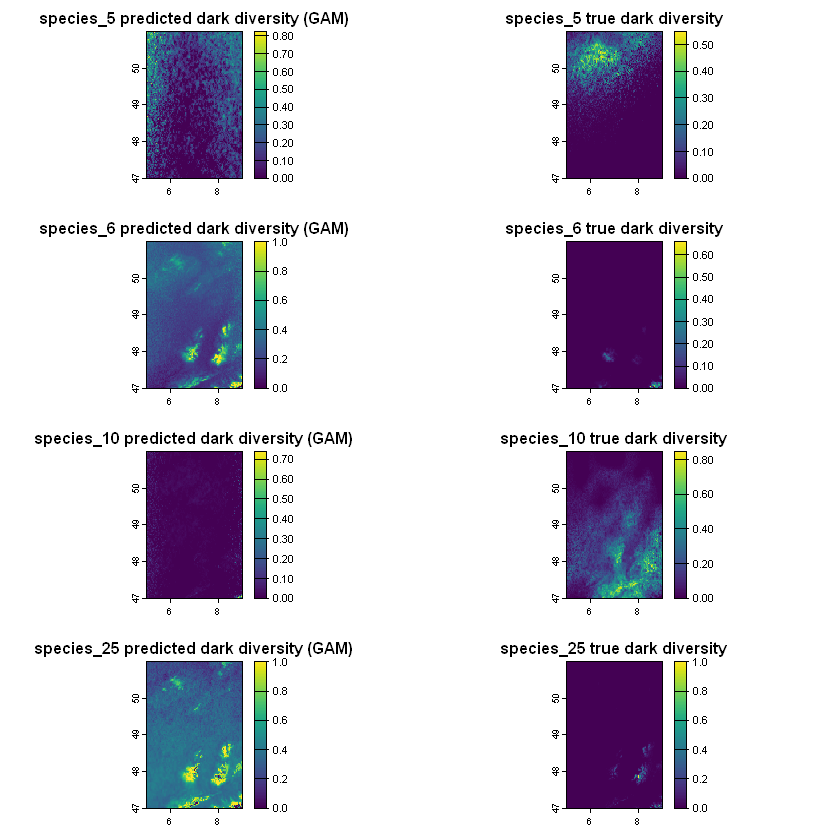

In [182]:
# Fit the dark diversity models using GAM and random forest

dd_mod_gam <- fit_dark_div(
    resp_mat = dark_div_zerofilled,
    points = plots,
    envs = envs,
    model = "gam"
)

# Plot the fitted models for GAM
par(bg = "white", mfrow = c(4, 2))

# Rather than plotting all species all the time, we can plot a few
gam_sp <- plot_species
for (s in gam_sp) {
    plot(dd_mod_gam[[s]]$prediction, main = paste0(
        s, " predicted dark diversity (GAM)"
    ))
    plot(dark_dist_stack[[s]], main = paste0(
        s, " true dark diversity"
    ))
}


## 5.2 Fitting the RF interpolation model

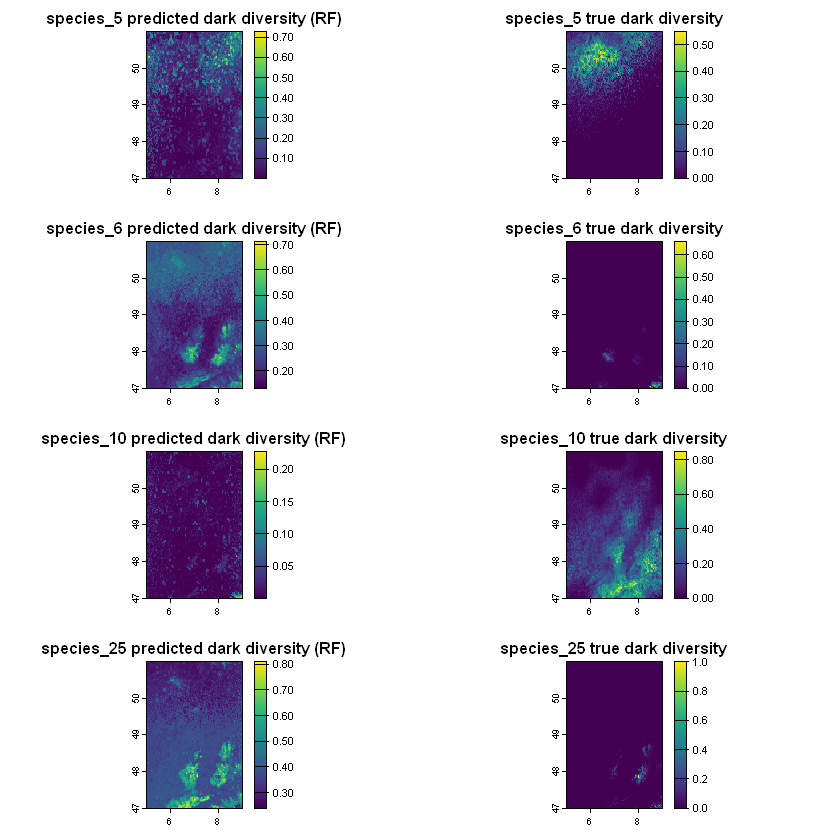

In [183]:
dd_mod_rf <- fit_dark_div(
    resp_mat = dark_div_zerofilled,
    points = plots,
    envs = envs,
    model = "randomForest"
)

# Plot the fitted models for random forest
par(bg = "white", mfrow = c(4, 2))

rf_sp <- plot_species
for (s in rf_sp) {
    plot(dd_mod_rf[[s]]$prediction, main = paste0(
        s, " predicted dark diversity (RF)"
    ))
    plot(dark_dist_stack[[s]], main = paste0(
        s, " true dark diversity"
    ))
}


Visually we can see that the dark diversity prediction does not match the true dark diversity. In particular, the spatially interpolated dark diversity prediction is much more extensive spatially than the true dark diversity. This is likely due to the fact that the dark diversity is only calculated at the sampled points, including where the species is not present, the dark diversity prediction is extrapolated beyond where the species can be present.

Therefore, we can try to constrain the dark diversity prediction to only areas where the species can exist, or is likely to exist using a species distribution model (SDM).

# 6. Constraining the dark diversity prediction with SDMs

First, we will need to fit a species distribution model (SDM) for each species. We will do this by fitting the observed species records to a GAM model. While here we are using a GAM, realistically any SDM could be used, such as a MaxEnt model. The point is that we want to have *a* model that predicts where a species can exist based on the environmental variables, which we can then use to constrain the dark diversity prediction. 

Warning message in lme.formula(y ~ X - 1, random = rand, data = strip.offset(mf), :
"nlminb problem, convergence error code = 1
  message = singular convergence (7)"
Warning message in lme.formula(y ~ X - 1, random = rand, data = strip.offset(mf), :
"nlminb problem, convergence error code = 1
  message = singular convergence (7)"


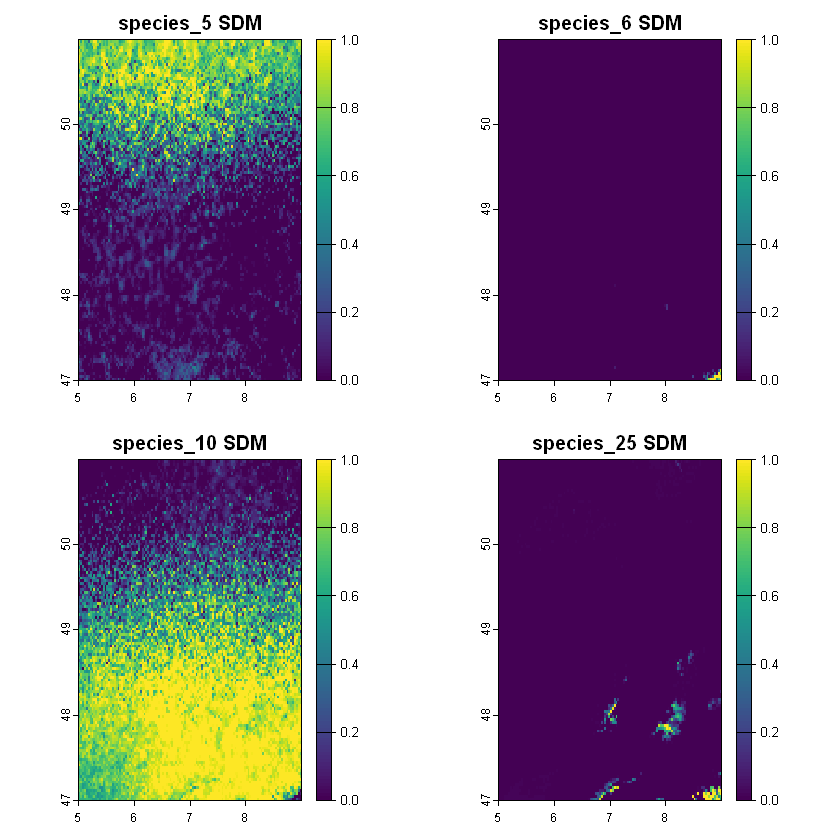

In [184]:
# Fitting SDMs for the 25 species
# Using different points for the SDMs to prevent double counting
plots_2 <- sample(all_plots, n_plots)

sp_mod_obs <- cbind(observations, env_data, terra::crds(plots_2))

# Drop columns that sum to 0
sp_mod_obs <- sp_mod_obs[, colSums(sp_mod_obs) > 0]

par(mfrow = c(2, 2), bg = "white")
sdm_list <- list()
for (i in seq_along(species)) {
    tryCatch(
        {
            mod_sp_mod <- mgcv::gamm(
                as.formula(
                    paste0(
                        species[i],
                        " ~ s(env_1) + s(env_2) + s(env_4) + s(env_5) + s(env_6)"
                    )
                ),
                data = sp_mod_obs,
            )
            sdm_list[[i]] <- predict(envs, mod_sp_mod$gam, type = "response") |>
                terra::clamp(0, 1)
            names(sdm_list[[i]]) <- paste0("sdm_", species[i])

            # plot(sdm_list[[i]], main = paste0(species[i], " SDM"))
            if (species[i] %in% plot_species) {
                plot(sdm_list[[i]], main = paste0(species[i], " SDM"))
            }
        },
        error = function(e) {
            cat("Error for species", i, ":", conditionMessage(e), "\n")
        }
    )
}
sdm_stack <- terra::rast(sdm_list)

## 6.1 Quick and dirty test

We can quickly test if using an SDM can improve the dark diversity prediction by simply multiplying the dark diversity prediction by the SDM probability. This is a quick and dirty test, but if it shows improvement in the output, we can then apply it properly as a covariate in the GAM model, or a more complex bayesian model (we will not be using this here, but it is an option for future extensions). 

In [185]:
pred_dark_stack <- lapply(dd_mod_gam$species, function(s) {
    x <- dd_mod_gam[[s]]$prediction
    names(x) <- s
    x
}) |> terra::rast()

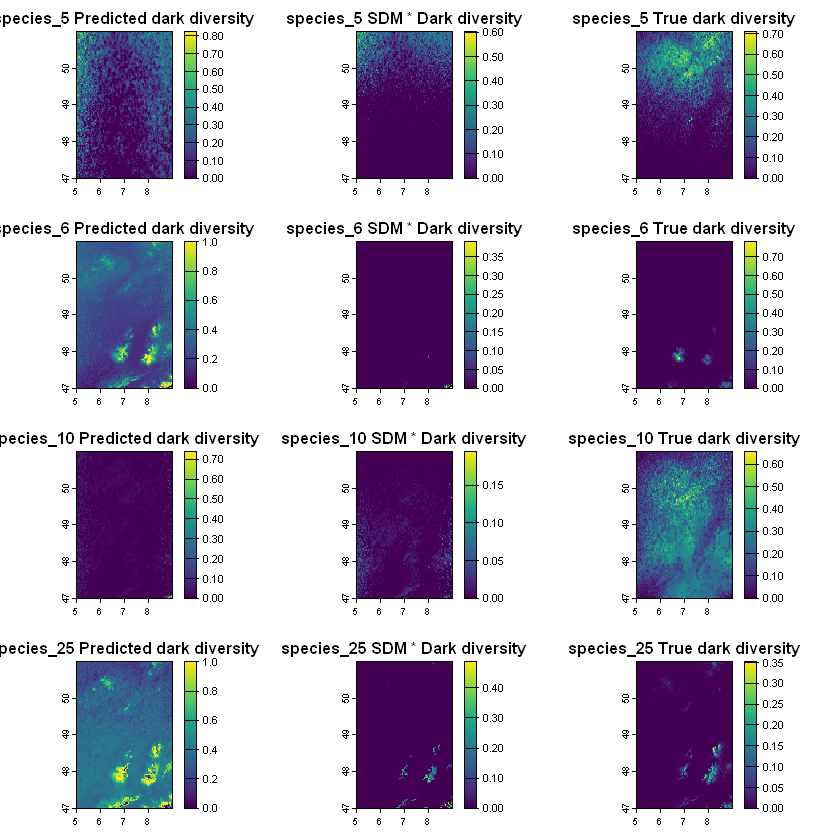

In [186]:
# # Checking which species are in both stacks
# intersect(names(pred_dark_stack), names(sdm_stack))
sdm_test_stack <- pred_dark_stack * sdm_stack

par(mfrow = c(4, 3), bg = "white")

for (i in plot_species) {
    plot(pred_dark_stack[[i]], main = paste0(i, " Predicted dark diversity"))
    plot(sdm_test_stack[[i]], main = paste0(i, " SDM * Dark diversity"))
    plot(true_dark_div[[i]], main = paste0(i, " True dark diversity"))
}


In these figures, we can see that the dark diversity prediction is closer to the true dark diversity, in that there is less prediction of dark diversity outside of where the species can exist.

Proving that this approach works, we can now implement it properly into the dark diversity model as a predictive covariate.

## 6.2 GAM model with SDM covariate

In [187]:
# Add the sdm predictions to the covariates
envs_sdms <- c(envs, sdm_stack)

sp_mod_obs_sdm <- cbind(dark_div_zerofilled, terra::extract(envs_sdms, plots)[, -1], terra::crds(plots))

# Fit the models again with the SDMs included
dark_mod_sdm_list <- list()

par(mfrow = c(5, 5), bg = "white")

for (i in 1:length(species)) {
    tryCatch(
        {
            sdm_dark_mod <- mgcv::gamm(
                as.formula(
                    paste0(
                        species[i], " ~ sdm_", species[i], " + s(env_1) + s(env_2) + s(env_4) + s(env_5) + s(env_6)"
                    )
                ),
                data = sp_mod_obs_sdm,
                # # Spatial autocorrelation
                # correlation = nlme::corExp(form = ~ x + y),
            )
            dark_mod_sdm_list[[i]] <- predict(envs_sdms, sdm_dark_mod$gam, type = "response") |>
                terra::clamp(0, 1)
            names(dark_mod_sdm_list[[i]]) <- species[i]
        },
        error = function(e) {
            cat("Error for species", species[i], ":", conditionMessage(e), "\n")
        }
    )
}
dark_mod_sdm_stack <- terra::rast(dark_mod_sdm_list)

Warning message in lme.formula(y ~ X - 1, random = rand, data = strip.offset(mf), :
"nlminb problem, convergence error code = 1
  message = singular convergence (7)"


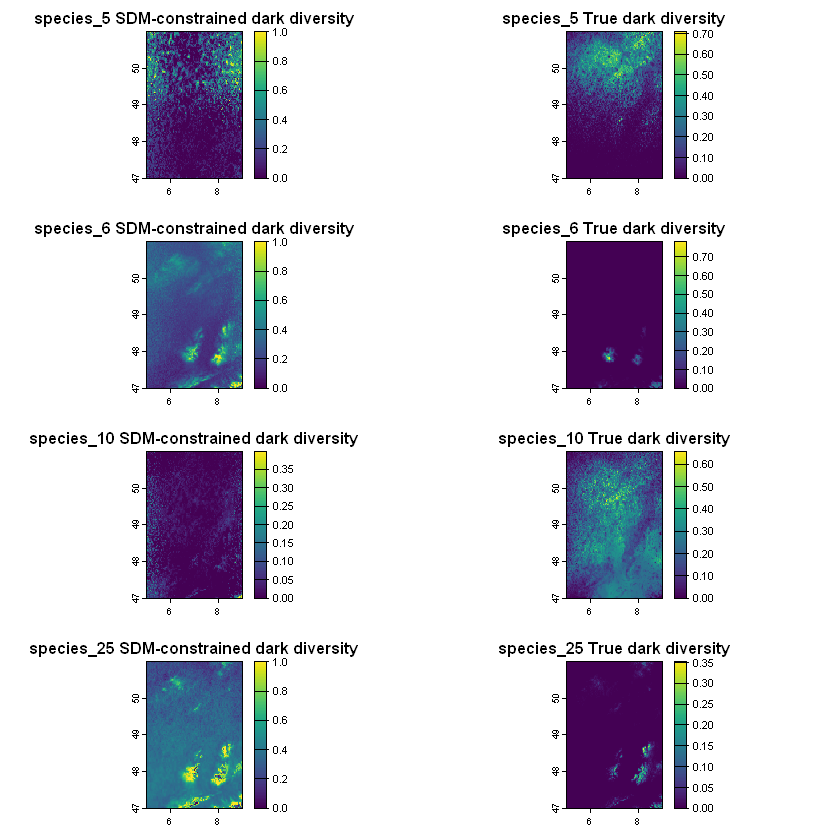

In [188]:
# Plotting the SDM-constrained dark diversity predictions against true dark diversity
par(mfrow = c(4, 2), bg = "white")
for (i in plot_species) {
    plot(dark_mod_sdm_stack[[i]], main = paste0(
        i, " SDM-constrained dark diversity"
    ))
    plot(true_dark_div[[i]], main = paste0(
        i, " True dark diversity"
    ))
}
# for (i in 1:length(species)) {
#     plot(subset(dark_mod_sdm_stack, species[i]), main = species[i])
# }
# mtext("SDM covariate\ndark diversity", outer = TRUE, side = 1, line = -5, adj = 1, cex = 2)
# par(mfrow = c(5, 5), bg = "white")
# for (i in 1:length(species)) {
#     plot(subset(true_dark_div, species[i]), main = species[i])
# }
# mtext("True dark diversity", outer = TRUE, side = 1, line = -5, adj = 1, cex = 2)

Comparing the GAM model with and without the SDM covariate, we can see that the model with the SDM covariate has a significantly better fit to the data.

## 6.3 Alternative test by multiplying the SDM values with the dark diversity values

In [189]:
# Alternative test by multiplying the SDM values with the dark diversity values
# Should be more robust to other methods e.g. random forest and other ML methods
# names(sdm_test_stack) |> length()
# observations

pa_points <- cbind(terra::crds(plots), observations) |> as.data.frame()

par(bg = "white", mfrow = c(5, 5))

for (s in species) {
    # Filter the points to only the presences for each species
    presences <- pa_points[which(pa_points[, s] == 1), 1:2] |>
        terra::vect(geom = c("x", "y"))
    # Extract the SDM values for the presences and get the minimum value as threshold
    threshold <- terra::extract(sdm_test_stack[[s]], presences)[, 2] |> min()
    print(paste("Species:", s, "Threshold:", threshold))
    # Clamp the values to all be between 0 and the threshold, and rescale to 0-1
    mod_sdm_stack[[s]] <- terra::clamp(sdm_test_stack[[s]], 0, threshold) / threshold
    plot(mod_sdm_stack[[s]])
}

[1] "Species: species_1 Threshold: 0.0350922354211753"


ERROR: Error: object 'mod_sdm_stack' not found


In [ ]:
sdm_multi_dark_prob <- dark_div_zerofilled * as.matrix(terra::extract(mod_sdm_stack, plots)[, -1])

sp_mod_obs_sdm_multiplied <- cbind(sdm_multi_dark_prob, terra::extract(envs_sdms, plots)[, -1], terra::crds(plots))

# Fit the models again with the SDMs included
dark_mod_sdm_multi_list <- list()

par(mfrow = c(5, 5), bg = "white")

for (i in 1:length(species)) {
    tryCatch(
        {
            sdm_dark_mod <- mgcv::gamm(
                as.formula(
                    paste0(
                        species[i], " + s(env_1) + s(env_2) + s(env_4) + s(env_5) + s(env_6)"
                    )
                ),
                data = sp_mod_obs_sdm,
                # # Spatial autocorrelation
                # correlation = nlme::corExp(form = ~ x + y),
            )
            dark_mod_sdm_multi_list[[i]] <- predict(envs_sdms, sdm_dark_mod$gam, type = "response") |>
                terra::clamp(0, 1)
            names(dark_mod_sdm_list[[i]]) <- species[i]
        },
        error = function(e) {
            cat("Error for species", species[i], ":", conditionMessage(e), "\n")
        }
    )
}
dark_mod_sdm_multi_stack <- terra::rast(dark_mod_sdm_multi_list)

Error for species species_1 : attempt to set an attribute on NULL 
Error for species species_2 : attempt to set an attribute on NULL 
Error for species species_3 : attempt to set an attribute on NULL 
Error for species species_4 : attempt to set an attribute on NULL 
Error for species species_5 : attempt to set an attribute on NULL 
Error for species species_6 : attempt to set an attribute on NULL 
Error for species species_7 : attempt to set an attribute on NULL 
Error for species species_8 : attempt to set an attribute on NULL 
Error for species species_9 : attempt to set an attribute on NULL 
Error for species species_10 : attempt to set an attribute on NULL 
Error for species species_11 : attempt to set an attribute on NULL 
Error for species species_12 : attempt to set an attribute on NULL 
Error for species species_13 : attempt to set an attribute on NULL 
Error for species species_14 : attempt to set an attribute on NULL 
Error for species species_16 : attempt to set an attribut

ERROR: Error in (function (cond) : error in evaluating the argument 'x' in selecting a method for function 'deepcopy': subscript out of bounds


In [ ]:
# Fit the models again with the SDMs included
dd_sdm_list <- list()

par(mfrow = c(5, 5), bg = "white")

for (i in 1:length(species)) {
    tryCatch(
        {
            sdm_dark_mod <- mgcv::gamm(
                species[i] ~ s(env_1) + s(env_2) + s(env_4) + s(env_5) + s(env_6),

                data = sp_mod_obs_sdm,
                # # Spatial autocorrelation
                # correlation = nlme::corExp(form = ~ x + y),
            )
            dark_mod_sdm_list[[i]] <- predict(envs_sdms, sdm_dark_mod$gam, type = "response") |>
                terra::clamp(0, 1)
            names(dark_mod_sdm_list[[i]]) <- species[i]
        },
        error = function(e) {
            cat("Error for species", species[i], ":", conditionMessage(e), "\n")
        }
    )
}
dark_mod_sdm_stack <- terra::rast(dark_mod_sdm_list)

# Quantifying the performance

How well do the different models for dark diversity perform? We can quantify the correlation between each method for spatial interpolation of dark diversity with the true dark diversity.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


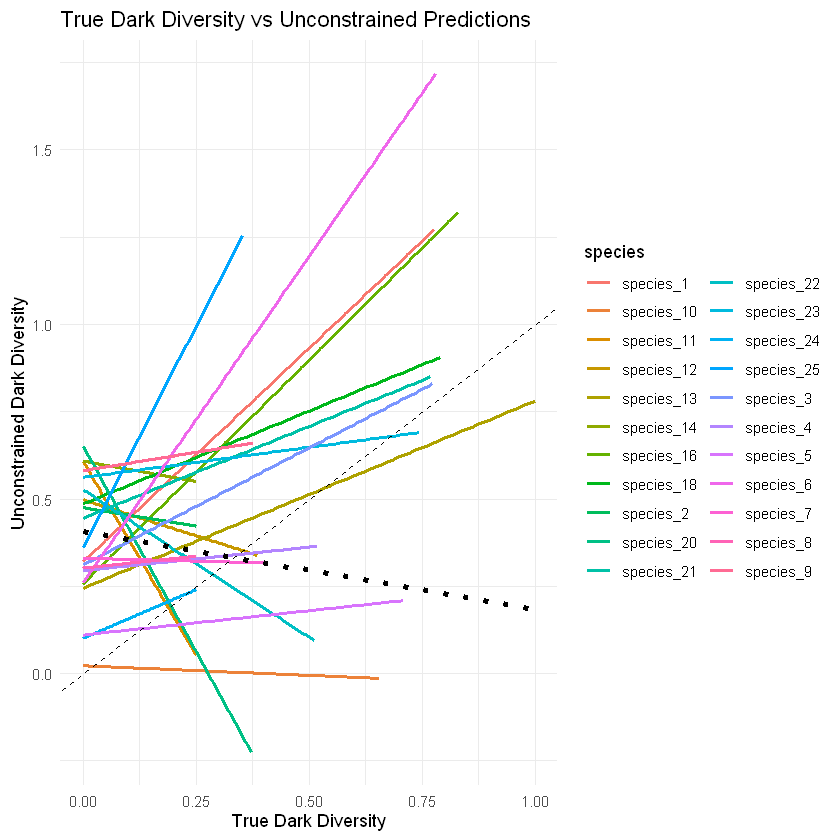

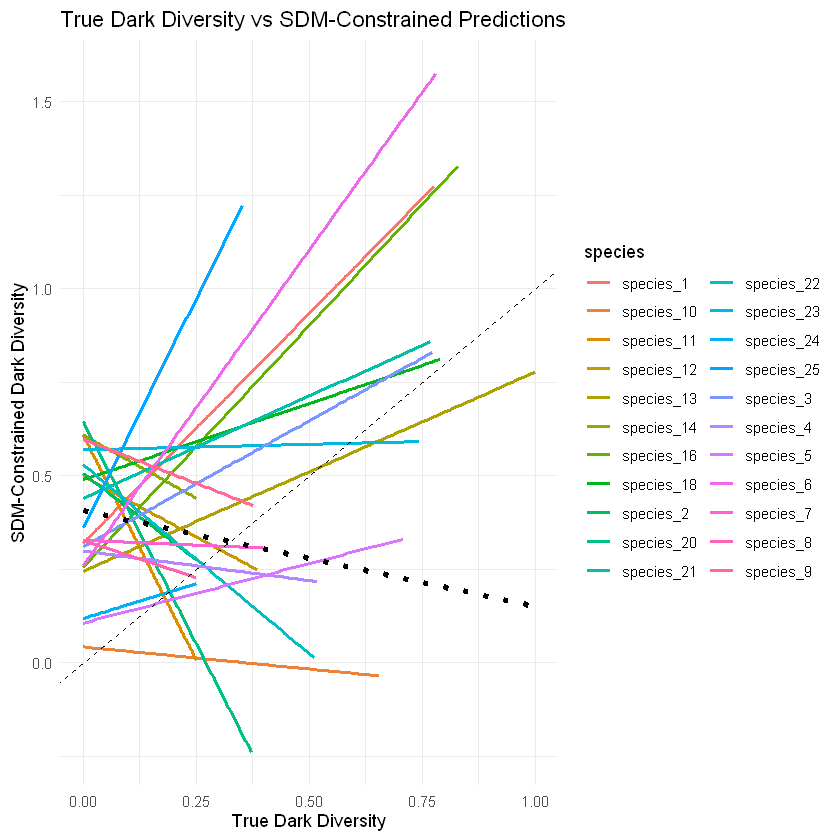

In [190]:
# True dark diversity
true_values <- values(subset(true_dark_div, species))

# Unconstrained dark diversity
uncons_pred_values <- values(pred_dark_stack)

# SDM-constrained dark diversity
sdm_pred_values <- values(dark_mod_sdm_stack)

# Pivot the dataframe longer labelled by species
true_long <- true_values |>
    as.data.frame() |>
    pivot_longer(
        cols = everything(),
        names_to = "species",
        values_to = "true_dark_div"
    )
uncons_long <- uncons_pred_values |>
    as.data.frame() |>
    pivot_longer(
        cols = everything(),
        names_to = "species",
        values_to = "unconstrained_dark_div"
    )
sdm_long <- sdm_pred_values |>
    as.data.frame() |>
    pivot_longer(
        cols = everything(),
        names_to = "species",
        values_to = "sdm_constrained_dark_div"
    )
# Combine the dataframes
cor_test_df <- cbind(
    true_long,
    uncons_long[, -1], # Remove the species column to avoid duplication
    sdm_long[, -1]
)

# Plotting the true dark diversity against the unconstrained and SDM-constrained predictions
ggplot(cor_test_df, aes(x = true_dark_div, y = unconstrained_dark_div, color = species)) +
    geom_smooth(method = "lm", se = FALSE) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black") +  # Add y = x line
    geom_smooth(aes(x = true_dark_div, y = unconstrained_dark_div), method = "lm", se = FALSE, color = "black", linetype = "dotted", linewidth = 1.5) + # Mean correlation line
    labs(
        title = "True Dark Diversity vs Unconstrained Predictions",
        x = "True Dark Diversity",
        y = "Unconstrained Dark Diversity"
    ) +
    theme_minimal() +
    theme()

ggplot(cor_test_df, aes(x = true_dark_div, y = sdm_constrained_dark_div, color = species)) +
    geom_smooth(method = "lm", se = FALSE) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black") + # Add y = x line
    geom_smooth(aes(x = true_dark_div, y = sdm_constrained_dark_div), method = "lm", se = FALSE, color = "black", linetype = "dotted", linewidth = 1.5) + # Mean correlation line
    labs(
        title = "True Dark Diversity vs SDM-Constrained Predictions",
        x = "True Dark Diversity",
        y = "SDM-Constrained Dark Diversity"
    ) +
    theme_minimal() +
    theme()

In [ ]:
# Calculate the correlation R between true dark diversity and predictions
cor_uncons <- cor(combined_df$true_dark_div, combined_df$unconstrained_dark_div, use = "complete.obs")
cor_test_uncons <- cor.test(combined_df$true_dark_div, combined_df$unconstrained_dark_div, use = "complete.obs")
cor_sdm <- cor(combined_df$true_dark_div, combined_df$sdm_constrained_dark_div, use = "complete.obs")
cor_test_sdm <- cor.test(combined_df$true_dark_div, combined_df$sdm_constrained_dark_div, use = "complete.obs")

cat("Correlation between true dark diversity and unconstrained predictions:", cor_uncons, "\n")
cat("Correlation test p-value:", cor_test_uncons$p.value, "\n")
cat("Correlation between true dark diversity and SDM-constrained predictions:", cor_sdm, "\n")
cat("Correlation test p-value:", cor_test_sdm$p.value, "\n")

ERROR: Error: object 'combined_df' not found


In [ ]:
# Break down the correlations by species
species_correlations <- combined_df |>
    group_by(species) |>
    summarise(
        cor_uncons = cor(true_dark_div, unconstrained_dark_div, use = "complete.obs"),
        cor_sdm = cor(true_dark_div, sdm_constrained_dark_div, use = "complete.obs"),
        cor_test_uncons = round(cor.test(true_dark_div, unconstrained_dark_div, use = "complete.obs")$p.value, 3),
        cor_test_sdm = round(cor.test(true_dark_div, sdm_constrained_dark_div, use = "complete.obs")$p.value, 3)
    )
# Add a column for the difference in correlations
species_correlations <- species_correlations |>
    mutate(correlation_difference = round(cor_sdm - cor_uncons, 2))
# Add a column for the percentage increase in correlation
species_correlations <- species_correlations |>
    mutate(percentage_increase = round((correlation_difference / abs(cor_uncons)) * 100, 2))
# Add a column that says better or worse
species_correlations <- species_correlations |>
    mutate(
        improvement = ifelse(correlation_difference > 0, "Better", "Worse")
    )
species_correlations

ERROR: Error: object 'combined_df' not found


Given that the dark diversity is within the range of the species distributions (by how we defined it), we should check that the improvement in the model is not simply because it is constrained to the range of the species distributions. We can plot the correlation between the true species distribution and the true dark diversity, and then the correlation between the true species distribution and the predicted dark diveristy. 


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


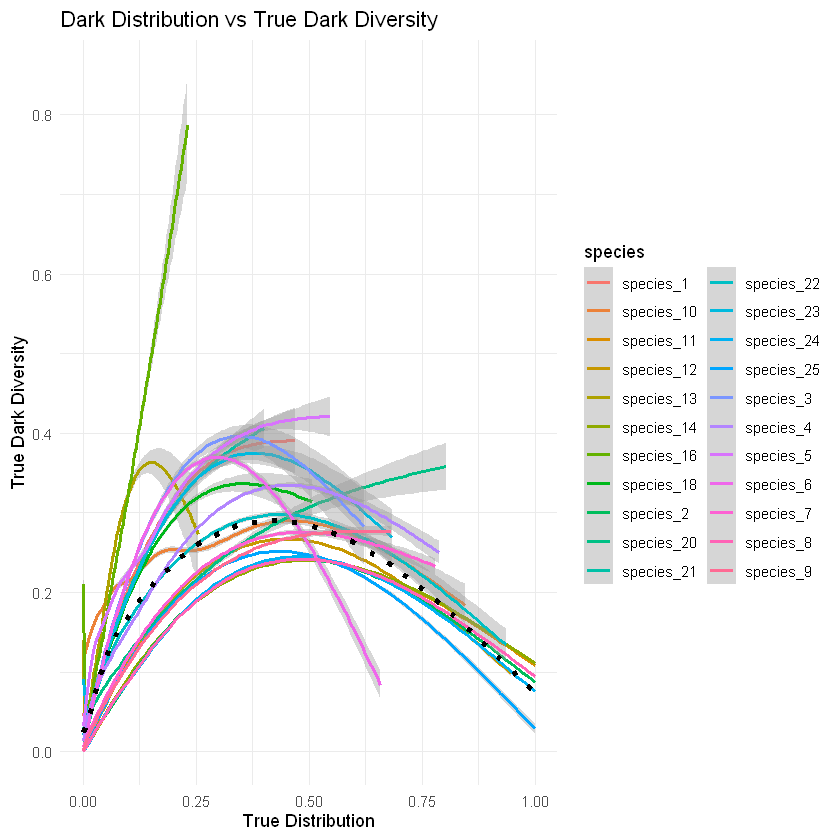

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


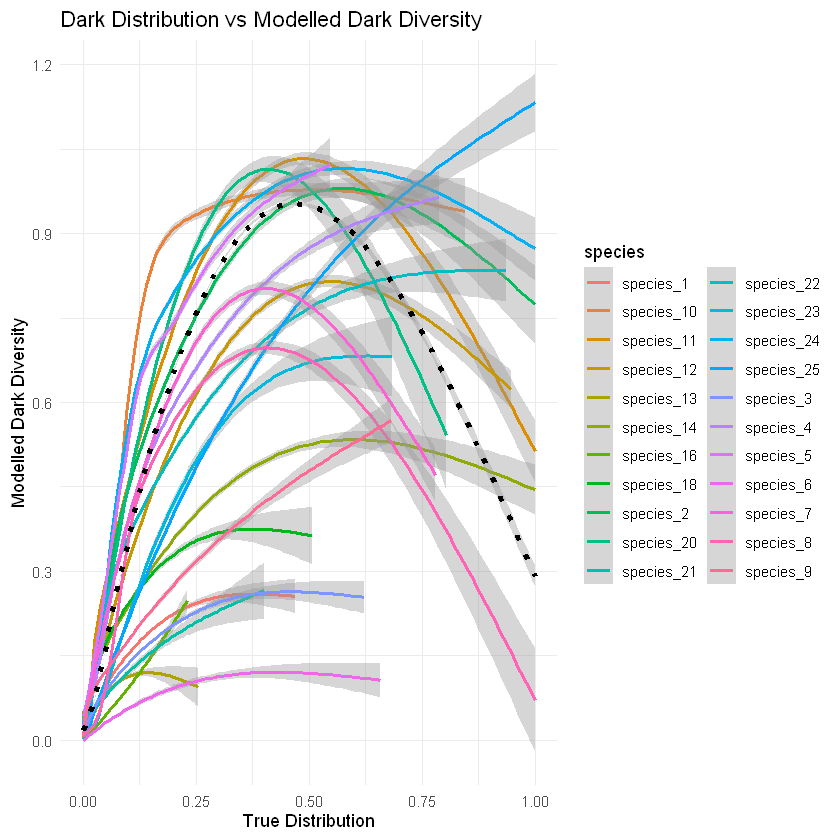

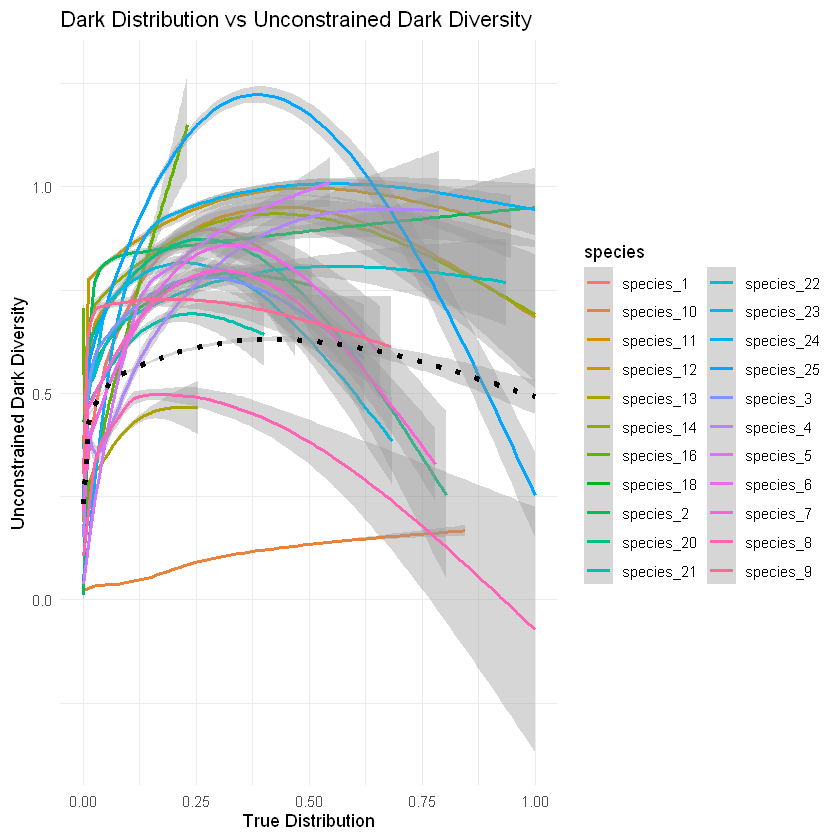

In [ ]:
# Subsetting to only include the species that we have predictions for
true_dist_values <- terra::values(terra::subset(dark_dist_stack, species))

true_dist_long <- true_dist_values |>
    as.data.frame() |>
    pivot_longer(
        cols = everything(),
        names_to = "species",
        values_to = "true_sdm"
    )

sdm_cor_df <- cbind(
    true_dist_long,
    true_long[, -1], # Remove the species column to avoid duplication
    sdm_long[, -1],
    uncons_long[, -1]
)

# Plotting the true dark diversity against the unconstrained and SDM-constrained predictions
ggplot(sdm_cor_df, aes(x = true_sdm, y = true_dark_div, color = species)) +
    geom_smooth(se = TRUE) +
    geom_smooth(aes(x = true_sdm, y = true_dark_div), se = FALSE, color = "black", linetype = "dotted", linewidth = 1.5) + # Mean correlation line
    labs(
        title = "Dark Distribution vs True Dark Diversity",
        x = "True Distribution",
        y = "True Dark Diversity"
    ) +
    theme_minimal() +
    theme()

# Plotting the true dark diversity against the unconstrained and SDM-constrained predictions
ggplot(sdm_cor_df, aes(x = true_sdm, y = sdm_constrained_dark_div, color = species)) +
    geom_smooth(se = TRUE) +
    geom_smooth(aes(x = true_sdm, y = sdm_constrained_dark_div), se = TRUE, color = "black", linetype = "dotted", linewidth = 1.5) + # Mean correlation line
    labs(
        title = "Dark Distribution vs Modelled Dark Diversity",
        x = "True Distribution",
        y = "Modelled Dark Diversity"
    ) +
    theme_minimal() +
    theme()

ggplot(sdm_cor_df, aes(x = true_sdm, y = unconstrained_dark_div, color = species)) +
    geom_smooth(se = TRUE) +
    geom_smooth(aes(x = true_sdm, y = unconstrained_dark_div), se = TRUE, color = "black", linetype = "dotted", linewidth = 1.5) + # Mean correlation line
    labs(
        title = "Dark Distribution vs Unconstrained Dark Diversity",
        x = "True Distribution",
        y = "Unconstrained Dark Diversity"
    ) +
    theme_minimal() +
    theme()


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


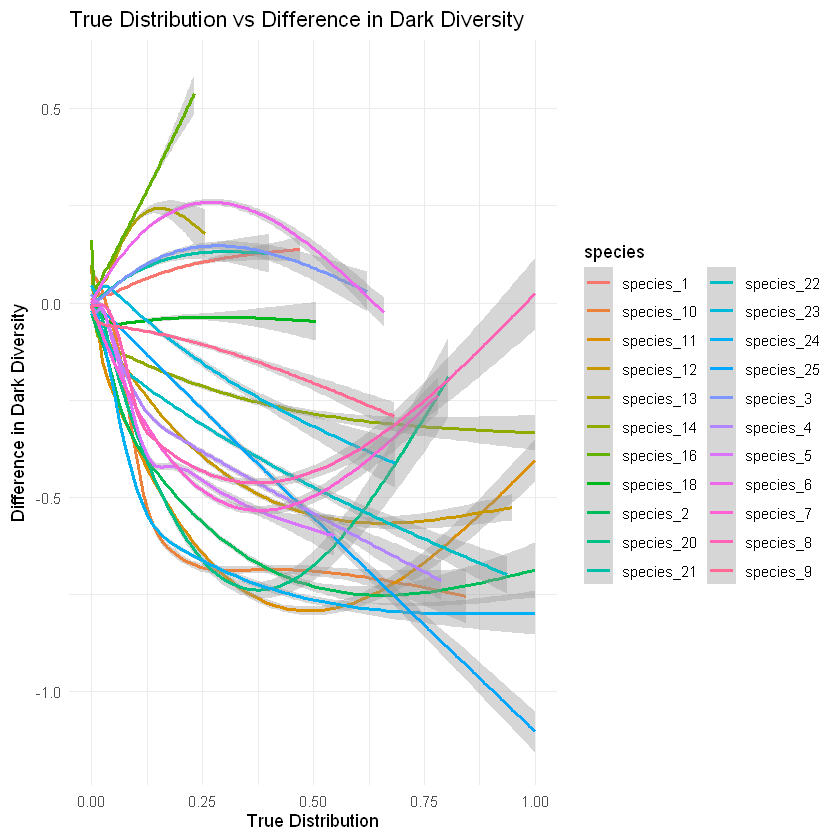

In [ ]:
sdm_cor_df$line_diff <- sdm_cor_df$true_dark_div - sdm_cor_df$sdm_constrained_dark_div

ggplot(sdm_cor_df, aes(x = true_sdm, y = line_diff, color = species)) +
    geom_smooth(se = TRUE) +
    # geom_smooth(aes(x = true_sdm, y = line_diff), se = TRUE, color = "black", linetype = "dotted", linewidth = 1.5) + # Mean correlation line
    labs(
        title = "True Distribution vs Difference in Dark Diversity",
        x = "True Distribution",
        y = "Difference in Dark Diversity"
    ) +
    theme_minimal() +
    theme()

Across these methods, we can see that first in both cases, that there is some positive correlation between the predicted and true dark diversity, indicating that this overall approach of spatially interpolating dark diversity recaptures some of the true dark diversity.

However, in the case of the model predicting purely from the dark diversity probability, the correlation is often very low, and the values are on average much higher than predicted. 

When the SDM covariate is included, the correlation is much higher, and the values are much closer to the true dark diversity, particularly in the low end of the probability values. 

This demonstrates that this approach of using an SDM to constrain the dark diversity prediction is effective, and that the overall method of spatially interpolating dark diversity is able to reproduce enough of the true dark diversity to be useful in practice.

# Appendix

## 1. Testing if the SDM calculated post-dark diversity matches the original distribution

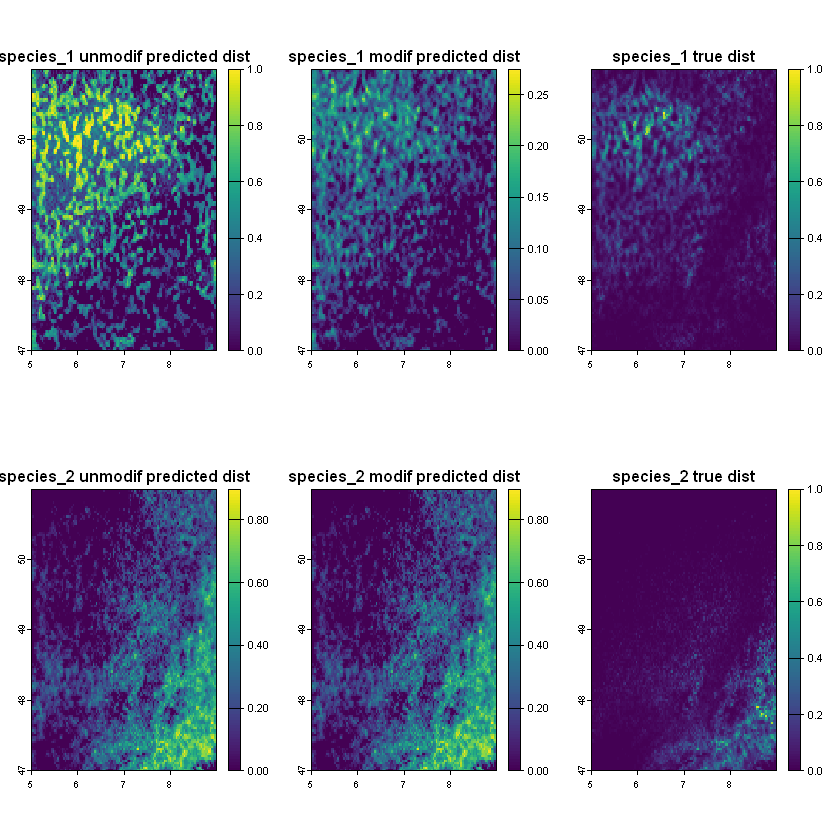

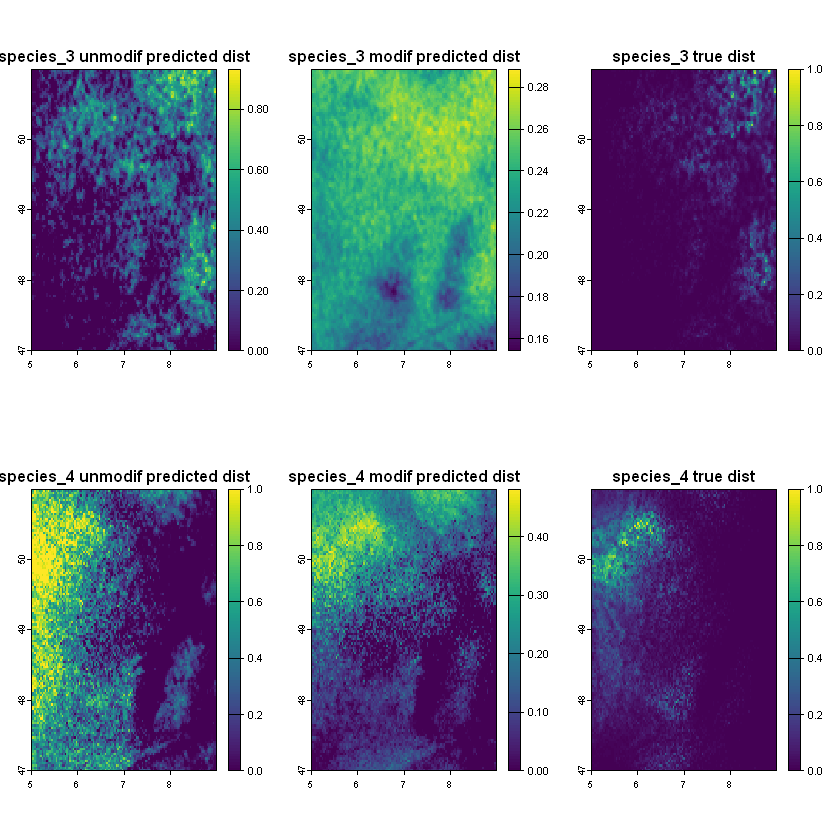

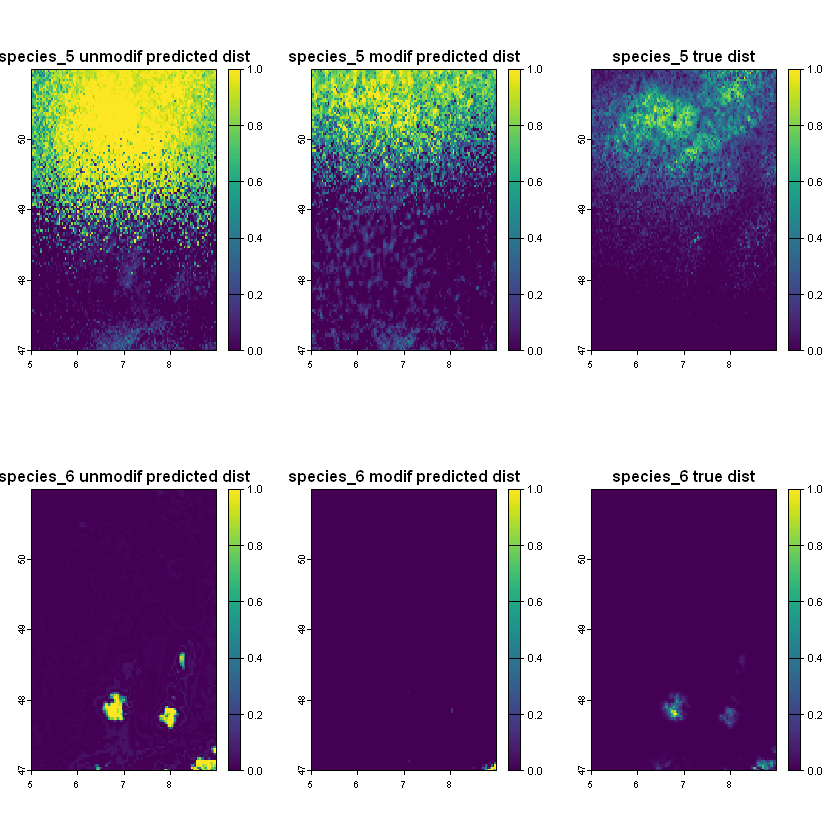

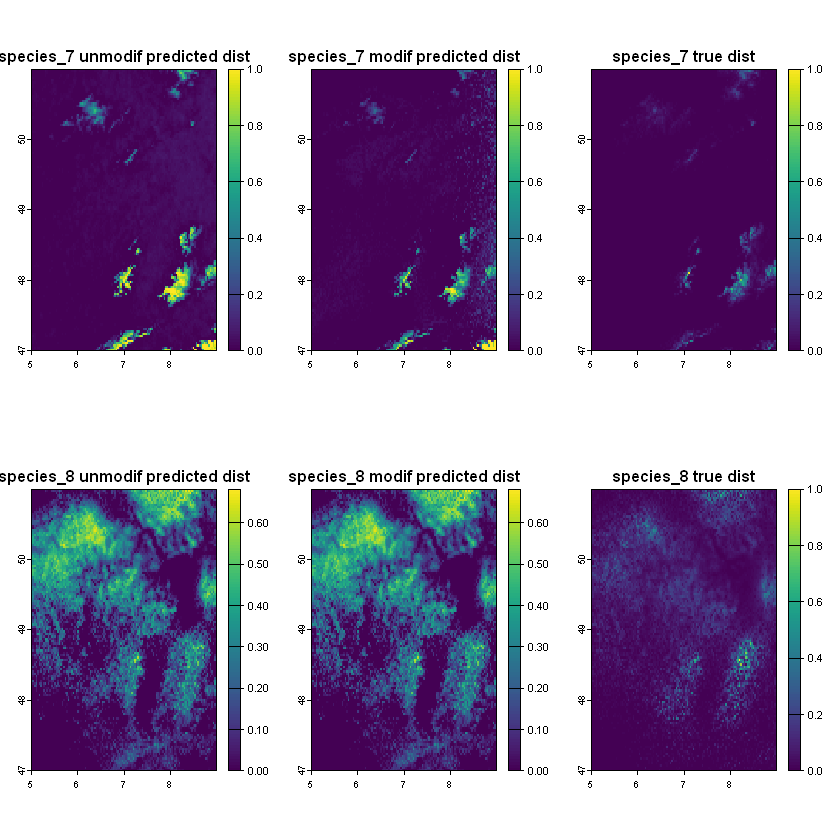

Warning message in lme.formula(y.0 ~ X - 1, random = rand, data = strip.offset(mf), :
"nlminb problem, convergence error code = 1
  message = singular convergence (7)"
Warning message in lme.formula(y.0 ~ X - 1, random = rand, data = strip.offset(mf), :
"nlminb problem, convergence error code = 1
  message = singular convergence (7)"


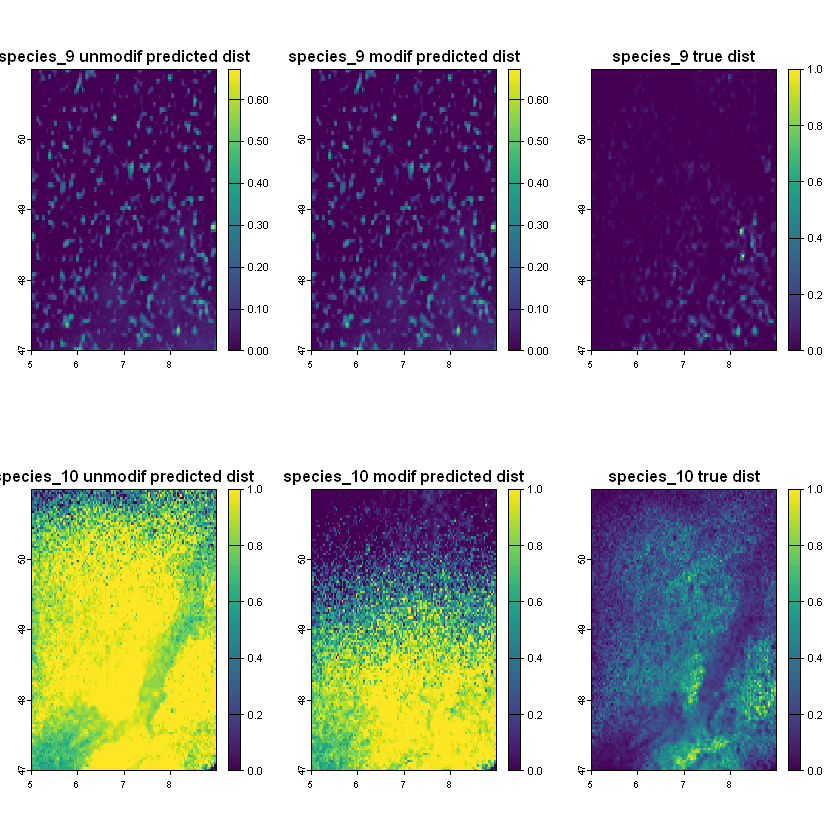

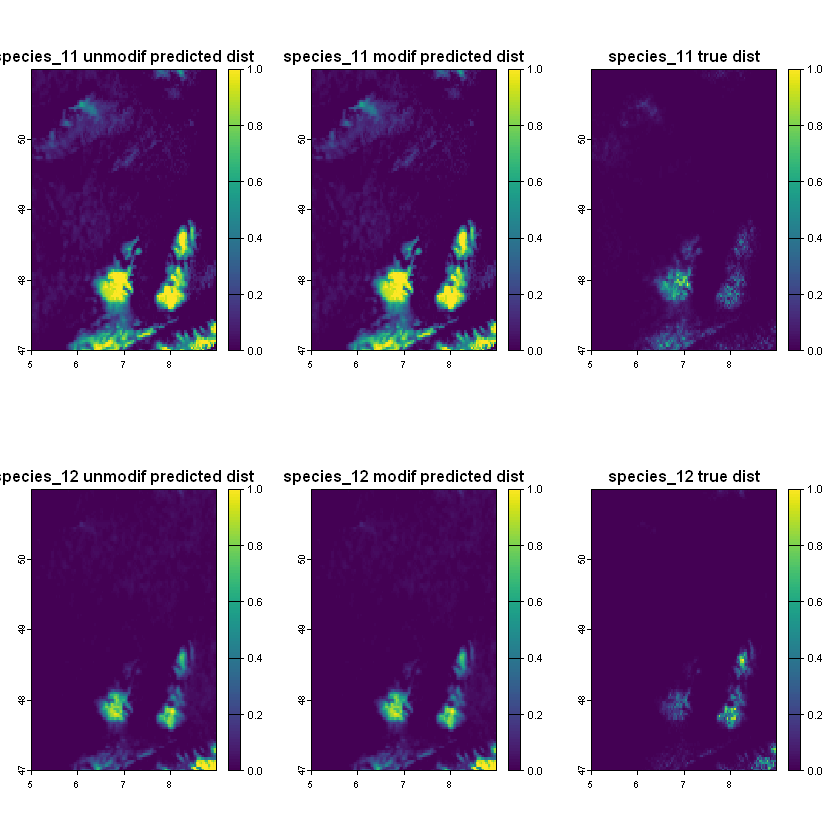

Warning message in lme.formula(y.0 ~ X - 1, random = rand, data = strip.offset(mf), :
"nlminb problem, convergence error code = 1
  message = singular convergence (7)"
Warning message in lme.formula(y.0 ~ X - 1, random = rand, data = strip.offset(mf), :
"nlminb problem, convergence error code = 1
  message = singular convergence (7)"


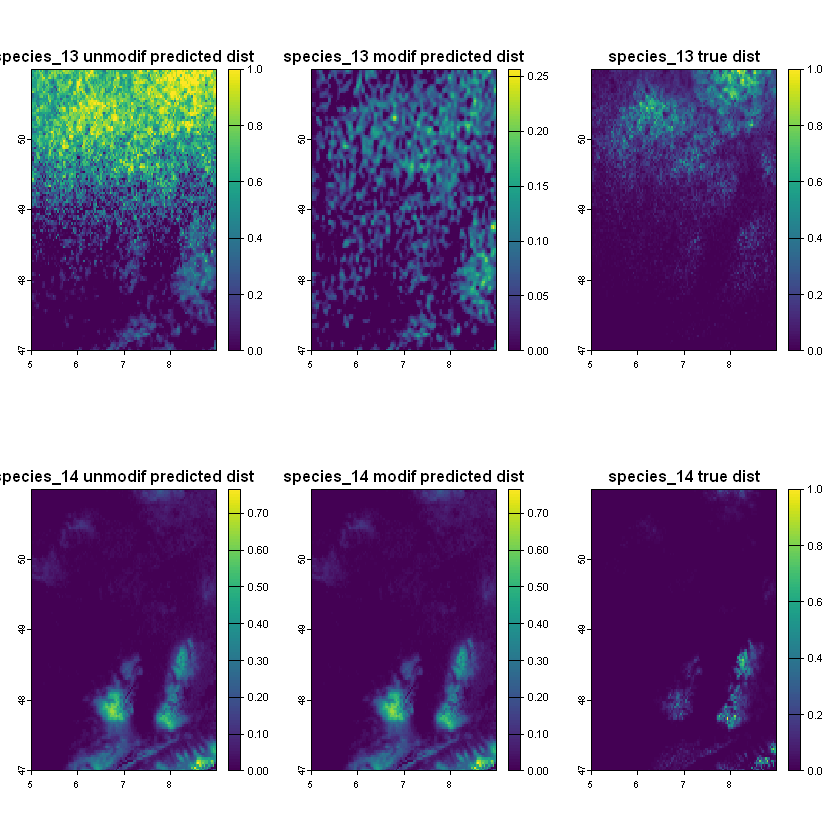

Error for species species_17 : the leading minor of order 1 is not positive 


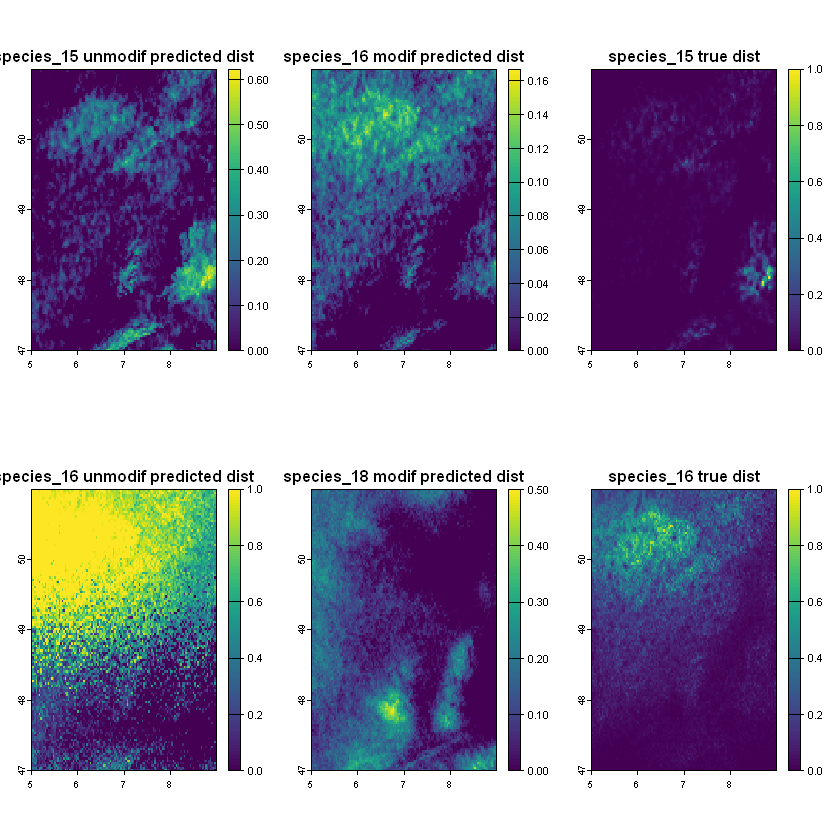

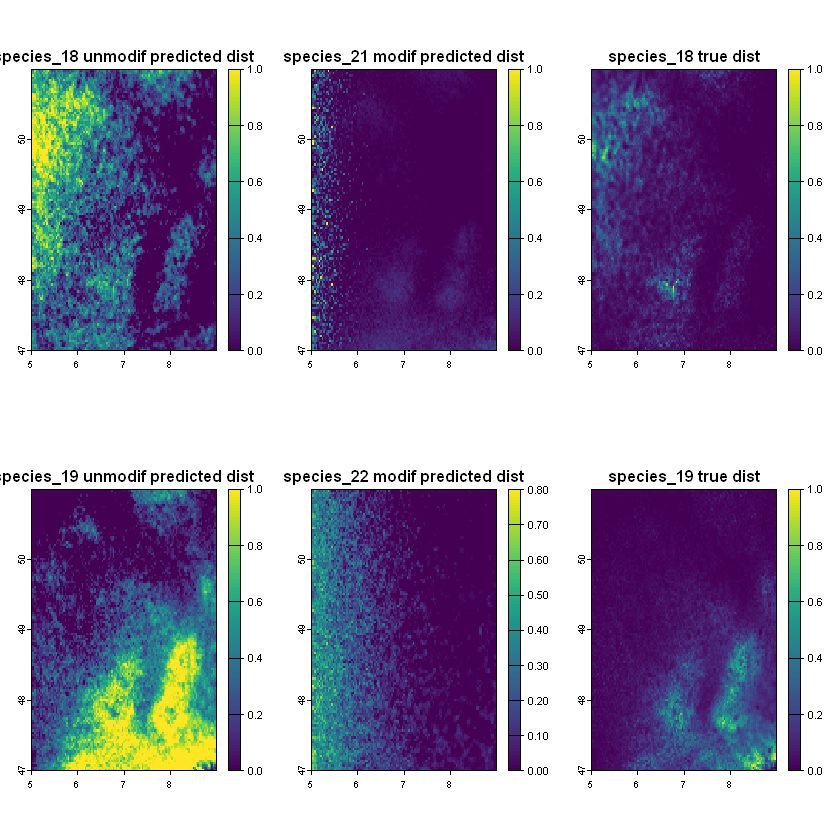

Warning message in lme.formula(y.0 ~ X - 1, random = rand, data = strip.offset(mf), :
"nlminb problem, convergence error code = 1
  message = false convergence (8)"


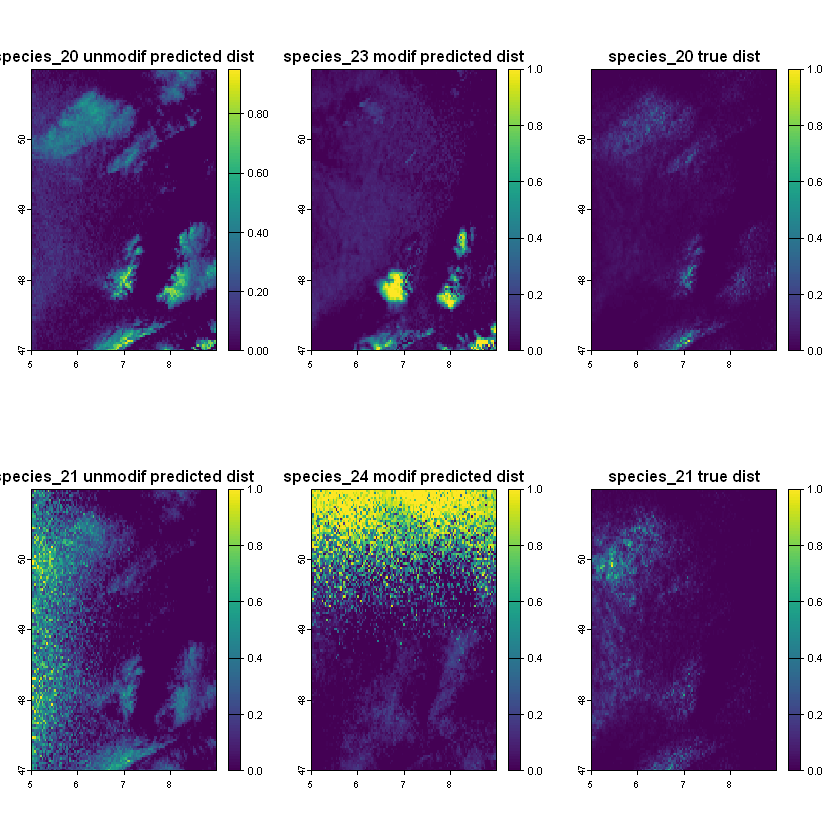

Warning message in lme.formula(y.0 ~ X - 1, random = rand, data = strip.offset(mf), :
"nlminb problem, convergence error code = 1
  message = false convergence (8)"
Warning message in lme.formula(y.0 ~ X - 1, random = rand, data = strip.offset(mf), :
"nlminb problem, convergence error code = 1
  message = false convergence (8)"


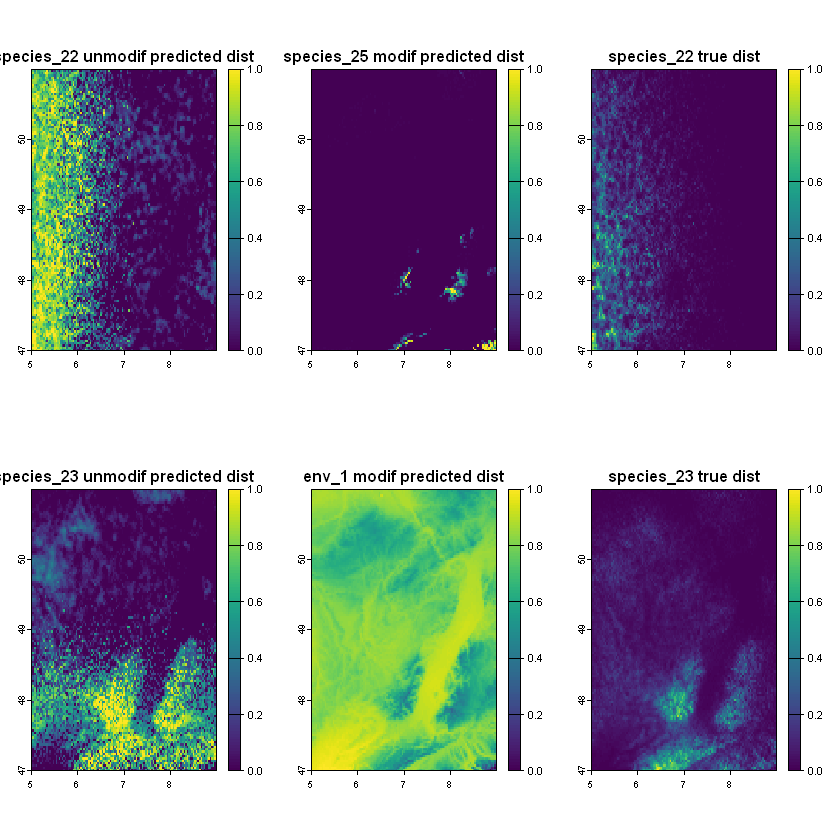

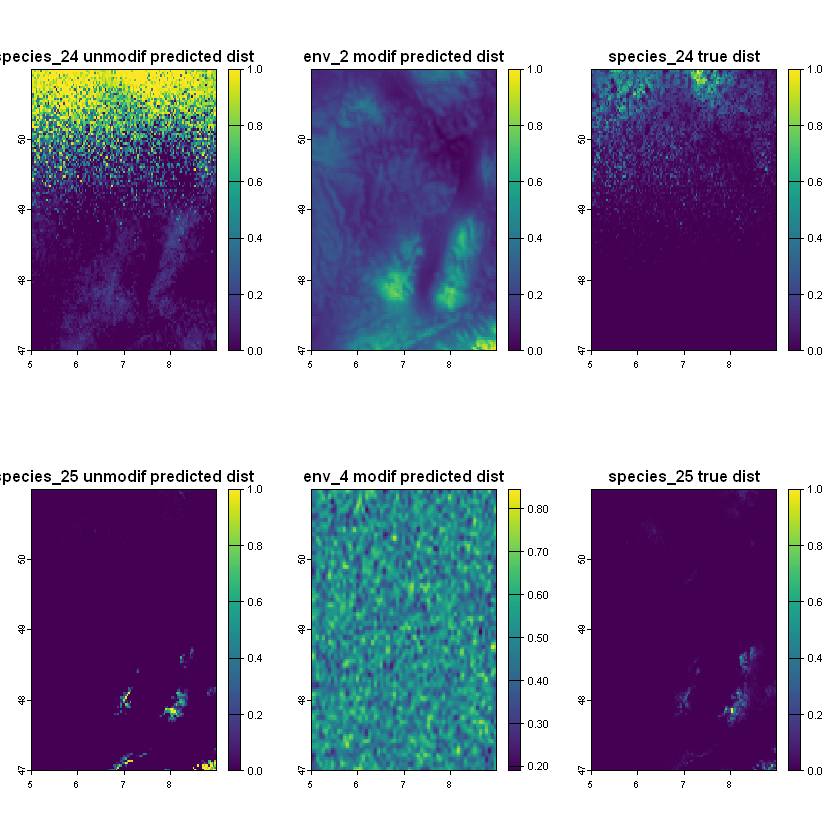

In [ ]:
# Recreating the species distribution pre dark diversity

sp_true_obs <- terra::extract(dist_stack, plots)[, -1] > threshold
sp_true_obs <- cbind(sp_true_obs, env_data, terra::crds(plots))

# Testing with the modified species distribution
sp_mod_obs <- cbind(observations, env_data, terra::crds(plots))

par(mfrow = c(2, 3), bg = "white")
modelled_sp_dist <- list()
mod_modelled_sp_dist <- list()
for (i in 1:25) {
    tryCatch({
        sp_mod <- mgcv::gamm(
            as.formula(
                paste0(
                    colnames(sp_true_obs)[i], " ~ s(env_1) + s(env_2) + s(env_4) + s(env_5) + s(env_6)"
                )
            ),
            data = sp_true_obs,
            # Spatial autocorrelation
            correlation = nlme::corExp(form = ~ x + y),
        )
        modelled_sp_dist[[i]] <- predict(envs, sp_mod$gam, type = "response") |>
            terra::clamp(0, 1)
        names(modelled_sp_dist[[i]]) <- colnames(sp_true_obs)[i]

        mod_sp_mod <- mgcv::gamm(
            as.formula(
                paste0(
                    colnames(sp_mod_obs)[i], " ~ s(env_1) + s(env_2) + s(env_4) + s(env_5) + s(env_6)"
                )
            ),
            data = sp_mod_obs,
            # Spatial autocorrelation
            correlation = nlme::corExp(form = ~ x + y),
        )
        mod_modelled_sp_dist[[i]] <- predict(envs, mod_sp_mod$gam, type = "response") |>
            terra::clamp(0, 1)
        names(mod_modelled_sp_dist[[i]]) <- colnames(sp_mod_obs)[i]

        plot(modelled_sp_dist[[i]], main = paste0(colnames(sp_true_obs)[i], " unmodif predicted dist"))
        plot(mod_modelled_sp_dist[[i]], main = paste0(colnames(sp_mod_obs)[i], " modif predicted dist"))
        plot(dist_stack[[i]], main = paste0(colnames(sp_true_obs)[i], " true dist"))
    }, error = function(e) {
        cat("Error for species", colnames(sp_true_obs)[i], ":", conditionMessage(e), "\n")
    })

}